### Data Preperation and Decision Tree implementation

In this notebook we will build a DecisionTree to predict the loan approval of a given customer. We are using the preprocessed data that was saved to the disk in Exploratory Data Analysis stage. Below are the detailed steps of the model building for DecisionTree.

1. Read the csv file and transform the data so that DecisionTree can be applied. The data transformations include converting categorical variables into numerical variables with the help of manual encoding.

2. Split the data for training and validation. Train data would contain 70% of the records and test data would hold 30% of the records.

3. Build the model and verify the results on train and test data.

4. Finetune the hyper parameters and experiment with the threshold values of the classifier.

5. Final Model Evaluation

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix,roc_auc_score,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier,export_graphviz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import pickle
import graphviz


In [2]:
df = pd.read_csv('./Data/processed_file.csv')

In [3]:
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income,Loan_Status,Ratio
0,LP001326,Male,No,0,Graduate,No,6782,0.0,130371.428571,360.0,1.0,Urban,6782.0,N,19.223154
1,LP001034,Male,No,1,Not Graduate,No,3596,0.0,100000.000000,240.0,0.0,Urban,3596.0,Y,27.808676
2,LP001052,Male,Yes,1,Graduate,No,3717,2925.0,151000.000000,360.0,1.0,Semiurban,6642.0,N,22.734116
3,LP001091,Male,Yes,1,Graduate,No,4166,3369.0,201000.000000,360.0,1.0,Urban,7535.0,N,26.675514
4,LP001123,Male,Yes,0,Graduate,No,2400,0.0,75000.000000,360.0,1.0,Urban,2400.0,Y,31.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71000.000000,360.0,1.0,Rural,2900.0,Y,24.482759
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40000.000000,180.0,1.0,Rural,4106.0,Y,9.741841
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253000.000000,360.0,1.0,Urban,8312.0,Y,30.437921
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187000.000000,360.0,1.0,Urban,7583.0,Y,24.660425


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Total_Income       614 non-null    float64
 13  Loan_Status        614 non-null    object 
 14  Ratio              614 non-null    float64
dtypes: float64(6), int64(1), object(8)
memory usage: 72.1+ KB


In [5]:
def process_data_for_tree(df):
    '''
    Preprocessing steps to implement Decision Tree
    
    Input :
        DataFrame to be transformed.
    
    Return :
        Transformed DataFrame
    '''
    
    df['Gender'] = df['Gender'].replace({'Male':1,'Female':0})
    df['Married'] = df['Married'].replace({'No':0,'Yes':1})
    df['Education'] = df['Education'].replace({'Graduate':1,'Not Graduate':0})
    df['Self_Employed'] = df['Self_Employed'].replace({'Yes':1,'No':0})
    df['Loan_Status'] = df['Loan_Status'].replace({'Y':1,'N':0})
    df['Dependents'] = df['Dependents'].replace({'0':0,'1':1,'2':2,'3+':3})
    df['Property_Area'] = df['Property_Area'].replace({'Rural':0,'Semiurban':1,'Urban':2})    
    
    return df[['Gender','Married','Dependents','Education','Self_Employed','ApplicantIncome','CoapplicantIncome',
               'LoanAmount','Loan_Amount_Term','Credit_History','Property_Area','Total_Income','Ratio','Loan_Status']]

In [6]:
df = process_data_for_tree(df)
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income,Ratio,Loan_Status
0,1,0,0,1,0,6782,0.0,130371.428571,360.0,1.0,2,6782.0,19.223154,0
1,1,0,1,0,0,3596,0.0,100000.000000,240.0,0.0,2,3596.0,27.808676,1
2,1,1,1,1,0,3717,2925.0,151000.000000,360.0,1.0,1,6642.0,22.734116,0
3,1,1,1,1,0,4166,3369.0,201000.000000,360.0,1.0,2,7535.0,26.675514,0
4,1,1,0,1,0,2400,0.0,75000.000000,360.0,1.0,2,2400.0,31.250000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,1,0,2900,0.0,71000.000000,360.0,1.0,0,2900.0,24.482759,1
610,1,1,3,1,0,4106,0.0,40000.000000,180.0,1.0,0,4106.0,9.741841,1
611,1,1,1,1,0,8072,240.0,253000.000000,360.0,1.0,2,8312.0,30.437921,1
612,1,1,2,1,0,7583,0.0,187000.000000,360.0,1.0,2,7583.0,24.660425,1


In [7]:
X,y = df.iloc[:,0:13],df.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 41)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

clf = DecisionTreeClassifier(random_state = 2020)
clf.fit(X_train,y_train)

train_pred = clf.predict(X_train)
print('Train Results :\n')
print('Confusion Matrix \n',confusion_matrix(y_train,train_pred))
print('Train Accuracy : ',clf.score(X_train,y_train))
print('Area under the curve : ',roc_auc_score(y_train,train_pred))
print('f1 score : ',f1_score(y_train,train_pred))


val_pred = clf.predict(X_test)
print('\nValidation Results :')
print('Confusion Matrix \n',confusion_matrix(y_test,val_pred))
print('validation Accuracy : ',clf.score(X_test,y_test))
print('Area under the curve : ',roc_auc_score(y_test,val_pred))
print('f1 score : ',f1_score(y_test,val_pred))

(429, 13) (185, 13) (429,) (185,)
Train Results :

Confusion Matrix 
 [[138   0]
 [  0 291]]
Train Accuracy :  1.0
Area under the curve :  1.0
f1 score :  1.0

Validation Results :
Confusion Matrix 
 [[ 23  31]
 [ 25 106]]
validation Accuracy :  0.6972972972972973
Area under the curve :  0.6175431156347186
f1 score :  0.791044776119403


Model fits with training set well but not with the test data. This is a symptom of over fitting. Decision Trees are prone to overfit inherently, we will have to prune the tree using the gridsearchcv to get the optimum results.

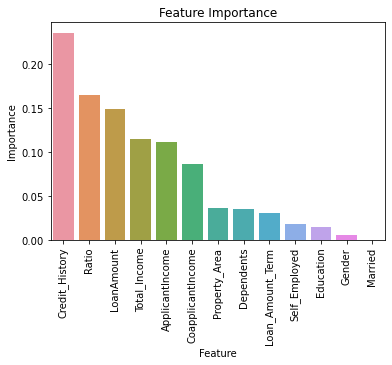

In [8]:
def plot_feat_imp(df,clf):
    '''
    Plots feature importance of a classifier for a given dataframe
    
    Input Parameters :
        df : Input dataframe
        clf : Classifier
    
    Returns :
        A plot object
        
    '''
    feat_imp = pd.DataFrame(list(zip(df.columns,clf.feature_importances_)),
                     columns = ['Feature','Importance']).sort_values(by = 'Importance',ascending = False)
    g = sns.barplot(x = 'Feature', y = 'Importance',data = feat_imp)
    g.set_title('Feature Importance')
    z = g.set_xticklabels(g.get_xticklabels(),rotation=90)
    return z

k = plot_feat_imp(df,clf)

Above data gives the feature importance for a fully grown tree but in real time, fully grown trees cannot fetch optimum results.

### Metrics for the problem Statement

As a startup the loan application approval system should balance between risk and customers. So we need a metric that has the capability to assess False Positive and False Negatives equally. f1_score is a metric defined as the harmonic mean of precision and recall. The ability to balance both Faslse Positive and False Negatives makes f1_score an apt metric for the problem statement. As the start up flourishes this strategy will be void, then the go to  metrics for the loan approval would be f1 beta score, beta value should be aligned with the new strategy.

<img src="./Screenshots/Strategy.jpg">

For pruning the decision tree, let us use gridsearchcv and tune the hyperparameters

In [9]:
params = {
    
    'max_depth' : [3,4,5],
    'min_impurity_decrease' : [0.1,0.2]
}
grid = GridSearchCV(estimator=clf, param_grid=params,cv = 5, scoring = 'f1',n_jobs = -1)
grid.fit(X_train,y_train)
grid.best_estimator_,grid.best_score_

(DecisionTreeClassifier(max_depth=3, min_impurity_decrease=0.1,
                        random_state=2020),
 0.8321148936774124)

In [10]:
grid_pred = grid.best_estimator_.predict(X_test)
print('f1 score of grid search on validation data: ',f1_score(y_test,grid_pred))
print('accuracy score of grid search on validation data: ',accuracy_score(y_test,grid_pred))
print('ROC score of grid search on validation data: ',roc_auc_score(y_test,grid_pred))
print('Confusion Matrix of grid search on validation data: \n',confusion_matrix(y_test,grid_pred))

f1 score of grid search on validation data:  0.8850174216027874
accuracy score of grid search on validation data:  0.8216216216216217
ROC score of grid search on validation data:  0.7162143059089623
Confusion Matrix of grid search on validation data: 
 [[ 25  29]
 [  4 127]]


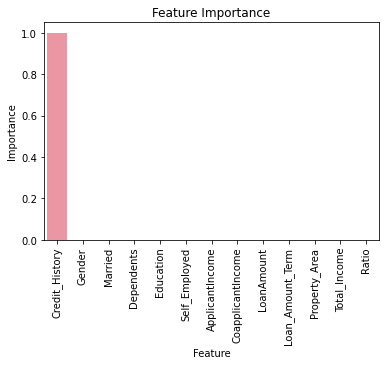

In [11]:
k = plot_feat_imp(df,clf = grid.best_estimator_)
#pd.DataFrame(list(zip(df.columns,grid.best_estimator_.feature_importances_)),columns = ['Feature','Importance']).sort_values(by = 'Importance',ascending = False).head()

In [12]:
export_graphviz(grid.best_estimator_, out_file = './Tree_files/tree_two_param.dot', feature_names = df.iloc[:,0:13].columns,filled = True)

In [13]:
!dot -Tpng ./Tree_files/tree_two_param.dot -o ./Tree_files/tree_two_param.png

<img src="./Tree_files/tree_two_param.png">
Fig-1 showing the tree structure.

As per the grid search the pruned decision tree is displayed above.

In [14]:
params = {
    
    'max_depth' : [2,3,4],
    
}
grid = GridSearchCV(estimator=clf, param_grid=params,cv = 5, scoring = 'f1',n_jobs = -1)
grid.fit(X_train,y_train)
print(grid.best_estimator_,grid.best_score_)

grid_pred = grid.best_estimator_.predict(X_test)
print('f1 score of grid search on validation data: ',f1_score(y_test,grid_pred))
print('accuracy score of grid search on validation data: ',accuracy_score(y_test,grid_pred))
print('ROC score of grid search on validation data: ',roc_auc_score(y_test,grid_pred))
print('Confusion Matrix of grid search on validation data: \n',confusion_matrix(y_test,grid_pred))

DecisionTreeClassifier(max_depth=2, random_state=2020) 0.8489262848684611
f1 score of grid search on validation data:  0.896797153024911
accuracy score of grid search on validation data:  0.8432432432432433
ROC score of grid search on validation data:  0.758693808312129
Confusion Matrix of grid search on validation data: 
 [[ 30  24]
 [  5 126]]


In [15]:
export_graphviz(grid.best_estimator_, out_file = './Tree_files/tree_one_param.dot', feature_names = df.iloc[:,0:13].columns,filled = True)

In [16]:
!dot -Tpng ./Tree_files/tree_one_param.dot -o ./Tree_files/tree_one_param.png

<img src="./Tree_files/tree_one_param.png">
Fig-2 showing the tree structure.

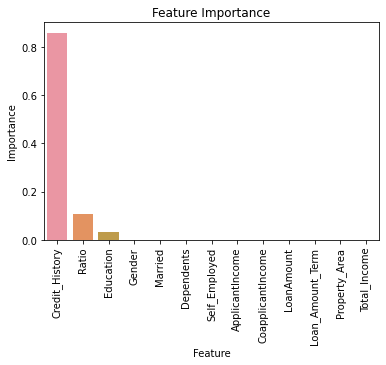

In [17]:
k = plot_feat_imp(df,clf = grid.best_estimator_)
#pd.DataFrame(list(zip(df.columns,grid.best_estimator_.feature_importances_)),columns = ['Feature','Importance']).sort_values(by = 'Importance',ascending = False).head()

<img src="./Screenshots/Confusion_Matrix_DT.jpg">

### Comparison of Models from Gridsearchcv

As the number of records are low, we have tried and tested two models through GridSearchCV with minimal combinations. The combinations tried are as follows:

1. params = { 
    
    'max_depth' : [3,4,5],          # controls the depth of the tree
    
    'min_impurity_decrease' : [0.1,0.2]             # Splitting of the nodes progress if there is a decrease in impurity atmost value set by the parameter. 
    }


2. params = {
    'max_depth':[2,3,4]                # controls the depth of the tree
    }

The first parameter space led to the decision tree of depth 1 and the feature contributing to the split is Credit_History. Please refer to the fig-1.

The second parameter space led to a decision tree of depth 2 and the features contributing to the split are Credit_History, Ratio and Education. Please refer to to fig-2.

Comparing both the models, the metrics do not vary by a large margin but f1 score for the second combination is higher and also reduces the False Positives and False Negatives without any dip in the True Positives and True Negatives compared to the first combination. 

In [18]:
pickle.dump(grid.best_estimator_, open('./Models/Decision_Tree.sav', 'wb'))

### Conclusion

From the above model, we can conclude that the following predictors have greater abaility to predict the outcome of the loan application. 

1. Credit_History 
2. Ratio 
3. Education 